In [1]:
#micrograd from scratch, the actual implementation, obtained from all the rough work :)

In [4]:
import math
import numpy as np  #type: ignore
import random
import matplotlib.pyplot as plt  #type: ignore
%matplotlib inline

In [609]:
#now implementing some functionalities of the micrograd code
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)  #done for efficiency
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None  #the base case
    
    def __repr__(self):
        return f"(data: {self.data}, operation: {self._op}, label: {self.label})"
    
    def __add__(self, other):  #other is another Value instance 
        other = other if isinstance(other, Value) else Value(other)  #so that we can add ints, floats etc 
        out = Value(self.data + other.data, (self, other), '+')   #returns back another Value instance

        def _backward():  #a func to setup the gradients of the child nodes of the outputted label node
            self.grad += out.grad   #+= used in both the cases to handle the multivariate case
            #where one label is used more than once 
            other.grad += out.grad
        
        out._backward = _backward  #has to be out, as the new value being spewn out of this is out
        return out
    
    def __radd__(self, other):  #is a fallback for __add__ where if the first obj is not Value type
        #then it falls back to this function where self becomes the right ele and not the left one,
        #and this internal swapping is done by python 
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return (self) + (-other)
    
    def __mul__(self, other): 
        other = other if isinstance(other, Value) else Value(other)  #so that we can add ints, floats etc 

        out = Value(self.data * other.data, (self, other), '*')     

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self, other):  #is a fallback for __mul__ function
        return self * other 
    
    def tanh(self):
        t = ((math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1))
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    

    def exp(self):
        e = math.exp(self.data)
        out = Value(e, (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad  #as out.data is just e^x which is the local gradient
            #and out.grad is the global gradient wrt this node required to have the effect of the 
            #gradients of the forward nodes
        
        out._backward = _backward
        return out

    def __pow__(self,other): 
        assert isinstance(other, (int, float))  #only letting the power be int or float for now
        p = self.data**other
        out = Value(p, (self, ), 'pow')

        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
            # other += (p)*(math.log(p))

        out._backward = _backward
        return out 
    
    def __truediv__(self, other):  #to handle division 
        return self * other**-1   #here onlt self, other is used directly which means that __mul__
        #and __pow__ funcs of the class are called
    
    def backward_prop(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for children_v in v._prev:
                    build_topo(children_v)
                topo.append(v)
        build_topo(self)  #calling it, essentially topo list now has the topologically sorted Value() objects, with the first
        #element being the child which is at the lowest depth of the graph, and the last ele being the uppermost parent

        self.grad = 1.0  #init value
        for v in reversed(topo):
            v._backward()


In [610]:
#using graphviz to draw the graph 
from graphviz import Digraph # type: ignore

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
        #creating a value node for it
        if n._op:
            dot.node(name = uid + n._op, label = n._op)  #creating op nodes which are more like
            #fake nodes
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [611]:
#writing the params of the neuron again so that this time the backprop can be done using functions
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'output'

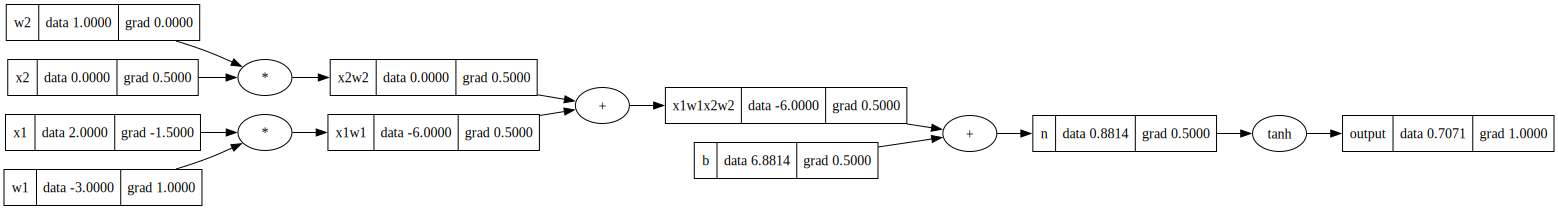

In [612]:
o.backward_prop()
draw_dot(o)

now we start building the neural net

In [613]:
class Neuron:
    def __init__(self, n_inputs):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)] #init n_inputs number of
        #weights for n_inputs number of inputs
        self.b = Value(random.uniform(-1,1))  
        #init the params to be random values bw -1 and 1 

    def __call__(self, x):  #will be call whenever you 
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)  #activation = W.X + b
        output = activation.tanh() 
        return output
    
    def params(self):
        return self.w + [self.b]

In [614]:
class Layer:
    #n_inputs correspond to the number of features, n_output corresponds to the number of 
    #neurons in that layer
    def __init__(self, n_inputs, n_output):  #n_outputs is the number of neurons in the layer
        self.neurons = [Neuron(n_inputs) for _ in range(n_output)]

    def __call__(self, x):
        output = [neuron(x) for neuron in self.neurons]
        return output[0] if len(output) == 1 else output
    
    def params(self):
        return [p for neuron in self.neurons for p in neuron.params()]

In [615]:
#now making the class which will define the MLP 
class MLP:
    def __init__(self, n_inputs, n_outputs_list):
        n_input_output_list = [n_inputs] + n_outputs_list

        #this creates a list with n_inputs present as the first element, and this is because, 
        #the first layer would take in n_inputs number of inputs as n_inputs is the number of
        #features present, and it also has n_outputs_list[0] number of neurons present, then in the 
        #second layer, it takes in n_outputs_list[0] number of inputs and n_outputs_list[1] number of 
        #neurons, and by takes in i mean that each neuron in that layer takes in 
        #n_outputs_list[0] number of inputs coming in from the first layer

        self.layers = [Layer(n_input_output_list[i], n_input_output_list[i+1]) for i in range(len(n_outputs_list))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)   #passing in the old x as the input to the next layer
        return x  #return the final output(the real one)

    def params(self):
        return [p for layer in self.layers for p in layer.params()]
    
    # def zero_grad(self):
    #     for p in self.params():
    #         p.grad = 0.0

In [629]:
n = MLP(3, [4, 4, 1])

In [630]:
X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

Y = [1.0, -1.0, -1.0, 1.0]

gradient descent

In [631]:
def gradient_descent(X, Y, epochs):
    for k in range(epochs):
        #forward pass
        ypred = [n(x) for x in X]
        loss = sum((yout - ygt)**2 for ygt, yout in zip(Y, ypred))

        #backward pass
        for p in n.params():  #setting all the grads to 0 before finding the grad for the new back run
            p.grad = 0.0
        loss.backward_prop()

        #update
        alpha = 0.05
        for p in n.params():
            p.data -= alpha*p.grad

        print(f"step: {k+1} loss: {loss}")

In [632]:
gradient_descent(X, Y, 20)

step: 1 loss: (data: 6.654462656075891, operation: +, label: )
step: 2 loss: (data: 4.1473912964256145, operation: +, label: )
step: 3 loss: (data: 2.098591376749151, operation: +, label: )
step: 4 loss: (data: 1.8346223009902694, operation: +, label: )
step: 5 loss: (data: 0.3017319704410194, operation: +, label: )
step: 6 loss: (data: 0.19009348509926793, operation: +, label: )
step: 7 loss: (data: 0.1558370445299586, operation: +, label: )
step: 8 loss: (data: 0.1321308815251116, operation: +, label: )
step: 9 loss: (data: 0.11446073432602116, operation: +, label: )
step: 10 loss: (data: 0.10077017310859882, operation: +, label: )
step: 11 loss: (data: 0.08986408585900621, operation: +, label: )
step: 12 loss: (data: 0.08098361362333016, operation: +, label: )
step: 13 loss: (data: 0.07362141844079592, operation: +, label: )
step: 14 loss: (data: 0.06742530335641167, operation: +, label: )
step: 15 loss: (data: 0.06214327839315928, operation: +, label: )
step: 16 loss: (data: 0.0575